In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline
colors = sns.color_palette('Set1', 9)
plt.rcParams["figure.figsize"] = (4,3)

In [31]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Player_Data.csv')
ocols = [x for x in df.columns if x.startswith('o_')]
dcols = [x for x in df.columns if x.startswith('d_')]

# Get the columns to perform K-means on
Xo = df[ocols].values
Xd = df[dcols].values

# Normalize values to 0 mean and 1 standard deviation
Xo_norm = StandardScaler().fit_transform(Xo)
Xd_norm = StandardScaler().fit_transform(Xd)

In [172]:
from sklearn.metrics import silhouette_score, silhouette_samples

def elbow(k_max, X, title):
    f, ax1 = plt.subplots(1, 1)
    elbow = {}
    scores = {}
    for k in range(2,k_max):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        elbow[k] = kmeans.inertia_
        labels = kmeans.labels_
        scores[k] = silhouette_score(X, labels)
    sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()),
                  color=colors[0], ax=ax1)
    ax1.set_title(title)
    ax1.set(xlabel='Clusters', ylabel='Sum of Squared Distances')
    ax2 = ax1.twinx()
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[1], ax=ax2)
    ax2.set(ylabel='Silhouette Score')
    ax2.grid(None)

    handles,labels = [],[]
    ax1.legend(handles=ax1.lines[::len(scores.keys())], labels=["Sum of Squares"],
              loc=1, bbox_to_anchor=(.995, 1))
    ax2.legend(handles=ax2.lines[::len(scores.keys())], labels=["Silhouette Score"],
              loc=1, bbox_to_anchor=(1, .92))

    

In [188]:
def aicBic(k_max, X, title):
    f, ax = plt.subplots(1, 1)
    aic = {}
    bic = {}
    scores = {}
    for k in range(2,k_max):
        gm = gmm(n_components=k, random_state=0).fit(X)
        aic[k] = gm.aic(X)
        bic[k] = gm.bic(X)
        labels = gm.predict(X)
        scores[k] = silhouette_score(X, labels)
    sns.pointplot(x=list(aic.keys()), y=list(aic.values()),
                  color=colors[0], ax=ax)
    sns.pointplot(x=list(bic.keys()), y=list(bic.values()),
                  color=colors[1], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='IC Score')
    ax2 = ax.twinx()
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[2], ax=ax2)
    ax2.set(ylabel='Silhouette Score')
    ax2.grid(None)
    
    ax.legend(handles=ax.lines[::len(aic.keys())+1],
              labels=["AIC","BIC"],
              loc=9, bbox_to_anchor=(.272, 1))
    ax2.legend(handles=ax2.lines[::len(scores.keys())], labels=["Silhouette Score"],
              loc=9, bbox_to_anchor=(.4, .83))

In [5]:
import matplotlib.cm as cm

def sil_scores(n, X, title, algo='Kmeans'):
    scores = {}
    for k in range(2, n):
        if algo=='Kmeans':
            kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
            labels = kmeans.labels_
        elif algo=='GMM':
            gm = gmm(n_components=k, random_state=0).fit(X)
            labels = gm.predict(X)
        scores[k] = silhouette_score(X, labels)
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x=list(scores.keys()), y=list(scores.values()),
                  color=colors[0], ax=ax)
    ax.set_title(title)
    ax.set(xlabel='Clusters', ylabel='Silhouette Score')

In [6]:
def silhouette(k, X, title, algo='Kmeans'):
    if algo=='Kmeans':
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
    elif algo == 'GMM':
        gm = gmm(n_components=k, random_state=0).fit(X)
        labels = gm.predict(X)
        centers = gm.means_
    sil_av = silhouette_score(X, labels)
    sil_samp = silhouette_samples(X, labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    y_lower = 10
    c_dict = {}
    for i in range(k):
        sil_vals = sil_samp[labels == i]
        sil_vals.sort()
        clust_size = sil_vals.shape[0]
        y_upper = y_lower + clust_size
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, sil_vals, facecolor=color,
                         edgecolor=color, alpha=.78)
        ax1.text(-0.05, y_lower + 0.5 * clust_size, str(i))
        y_lower = y_upper + 10
        c_dict[i] = colors[i]
    ax1.axvline(x=sil_av, color="red", linestyle="--")
    ax1.set_title('Silhouette Plot')
    ax1.set(xlabel='Silhouette Coefficient Values', ylabel='Cluster Label')
    ax1.set_yticks([])

    colors2 = [colors[x] for x in labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    ax2.set_title("Clustered Data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle((title),
                 fontsize=13, fontweight='bold')

In [60]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA

def transformDF(X, trans, title='', n=0):
    
    if trans == 'PCA':
        f, ax = plt.subplots(1, 1)
        n = len(X[0])
        pca = PCA(n_components=n, random_state=0)
        cols = ['PC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(pca.fit_transform(X), columns=cols)

        sns.pointplot(y=pca.explained_variance_ratio_,
                    x=[x for x in range(1,n+1)], color=colors[0],
                      ax=ax)
        sns.pointplot(y=np.cumsum(pca.explained_variance_ratio_),
                      x=[x for x in range(1,n+1)], color=colors[1],
                      ax=ax)

        ax.legend(
            handles=ax.lines[::len(pca.explained_variance_ratio_)+1],
                  labels=["Variance Explained","Cumulative Variance Explained"])
        ax.set_title(title)
        ax.set_xlabel("Components")
        ax.set_ylabel("Variance Explained")
        
    elif trans == 'ICA':
        f, ax = plt.subplots(1, 1)
        ica = ICA(n_components=n, random_state=0)
        cols = ['IC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(ica.fit_transform(X), columns=cols)
        dft = dft[dft.kurt(axis=0).abs().sort_values(ascending=False).index]
        sns.barplot(x=dft.kurt(axis=0).abs().sort_values(ascending=False), y=dft.columns,
                    color=colors[0], ax=ax)
        dft = dft[dft.kurt(axis=0).abs().sort_values(ascending=False).iloc[:-int(n/2)].index]
        ax.set_title(title)
        ax.set_xlabel("Kurtosis")
        ax.set_ylabel("Components")
        
    elif trans == 'RCA':
        rca = RP(n_components=n, random_state=0)
        cols = ['RC'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(rca.fit_transform(X), columns=cols)
        
    elif trans == 'FA':
        fa = FA(n_clusters=n)
        cols = ['FA'+str(x+1) for x in range(n)]
        dft = pd.DataFrame(fa.fit_transform(X), columns=cols)
        
    return dft

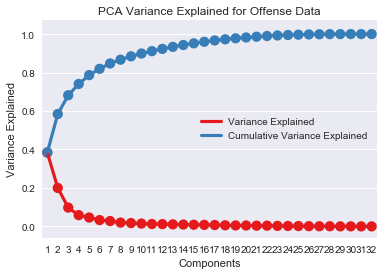

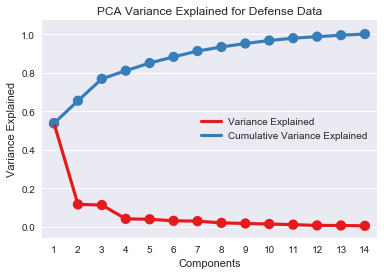

In [53]:
dfpcao = transformDF(Xo_norm, 'PCA', 'PCA Variance Explained for Offense Data')
dfpcad = transformDF(Xd_norm, 'PCA', 'PCA Variance Explained for Defense Data')

In [49]:
from sklearn.decomposition import FastICA as ICA

def elbowICA(X, title):
    elbow_all = {}
    elbow_top = {}
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    
    for k in range(2,n+1):
        df = pd.DataFrame(ICA(n_components=k, random_state=0).fit_transform(X))
        dfkurt = df.kurt(axis=0)
        elbow_all[k] = dfkurt.abs().mean()
        elbow_top[k] = dfkurt.abs().sort_values().iloc[int(k/2):].mean()
        
    sns.pointplot(x=list(elbow_all.keys()), y=list(elbow_all.values()),
                  color=colors[0], ax=ax)
    sns.pointplot(x=list(elbow_top.keys()), y=list(elbow_top.values()),
                  color=colors[1], ax=ax)
    ax.legend(
            handles=ax.lines[::len(elbow_all.keys())+1],
                  labels=["Kurtosis for All Components", "Kurtosis for Top 50% of Components"])
    ax.set_title(title)
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Kurtosis")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


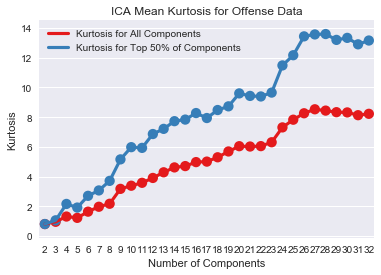

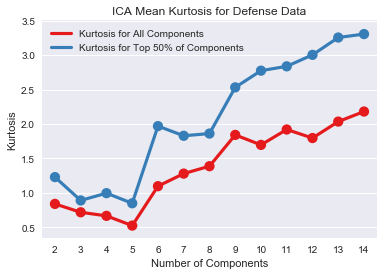

In [50]:
elbowICA(Xo_norm, 'ICA Mean Kurtosis for Offense Data')
elbowICA(Xd_norm, 'ICA Mean Kurtosis for Defense Data')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


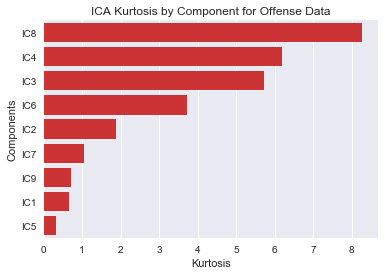

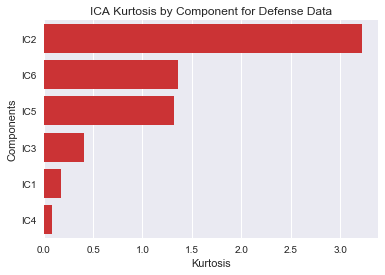

In [54]:
dficao = transformDF(Xo_norm, 'ICA', 'ICA Kurtosis by Component for Offense Data', 9)
dficad = transformDF(Xd_norm, 'ICA', 'ICA Kurtosis by Component for Defense Data', 6)

In [12]:
from sklearn.random_projection import GaussianRandomProjection as RP

def reconstructError(obj, X):
    if 'FeatureAgglomeration' in str(type(obj)):
        x_trans = obj.fit_transform(X)
        X_project = obj.inverse_transform(x_trans)
    elif 'GaussianRandomProjection' in str(type(obj)):
        X_trans = obj.fit_transform(X)
        mean = X.mean(axis=0)
        X_project = np.dot(X_trans, obj.components_) + mean
    return ((X - X_project) ** 2).mean()

def elbowRCA(X, title):
    df = pd.DataFrame()
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    for s in range(30):
        for k in range(2,n+1):
            df = df.append({'Reconstruction Error':reconstructError(RP(n_components=k,
                                                                       random_state=s), X),
                            'Components': int(k)}, ignore_index=True)
    df['Components'] = df['Components'].astype(int)
    sns.pointplot(x='Components', y='Reconstruction Error', data=df, scale=.75, markers='.',
                  color=colors[0], ax=ax)
    ax.set_title(title)

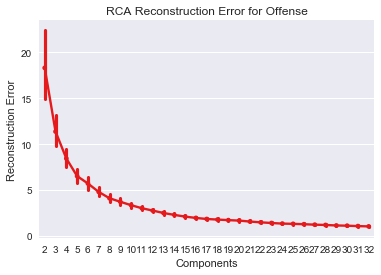

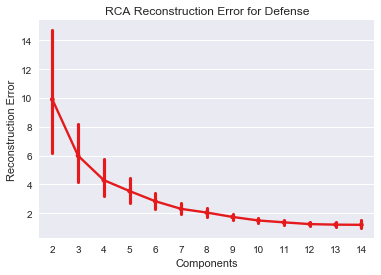

In [13]:
elbowRCA(Xo_norm, 'RCA Reconstruction Error for Offense')
elbowRCA(Xd_norm, 'RCA Reconstruction Error for Defense')

In [61]:
dfrcao = transformDF(Xo_norm, 'RCA', n=6)
dfrcad = transformDF(Xd_norm, 'RCA', n=4)

In [15]:
from sklearn.cluster import FeatureAgglomeration as FA

def elbowFA(X, title):
    df = pd.DataFrame()
    n = len(X[0])
    f, ax = plt.subplots(1, 1)
    for k in range(1,n+1):
        df = df.append({'Reconstruction Error':reconstructError(FA(n_clusters=k), X),
                        'Clusters': int(k)}, ignore_index=True)
    df['Clusters'] = df['Clusters'].astype(int)
    sns.pointplot(x='Clusters', y='Reconstruction Error', data=df,
                  color=colors[0], ax=ax)
    ax.set_title(title)

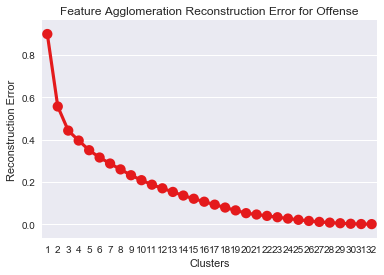

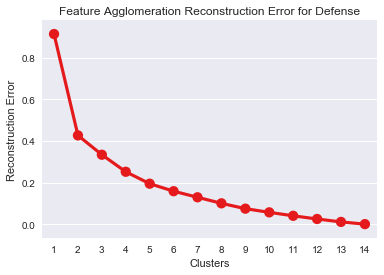

In [16]:
elbowFA(Xo_norm, 'Feature Agglomeration Reconstruction Error for Offense')
elbowFA(Xd_norm, 'Feature Agglomeration Reconstruction Error for Defense')

In [62]:
dffao = transformDF(Xo_norm, 'FA', n=5)
dffad = transformDF(Xd_norm, 'FA', n=5)

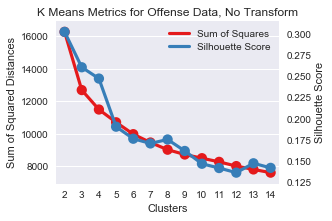

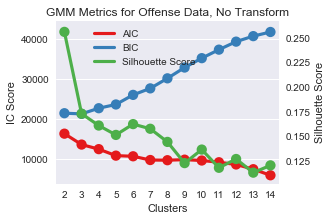

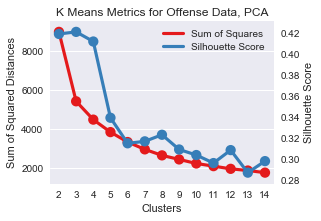

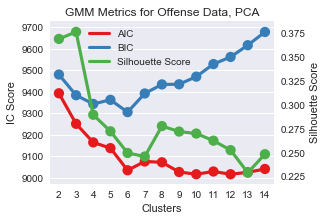

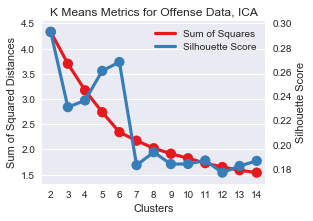

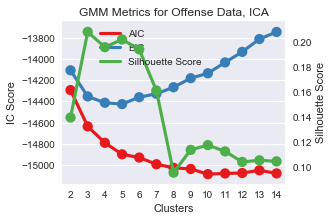

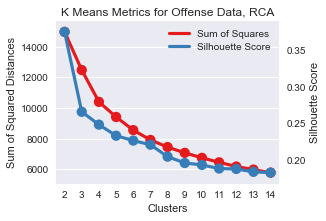

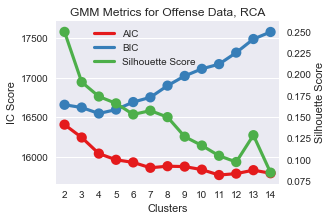

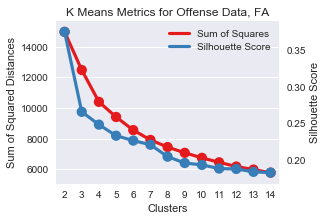

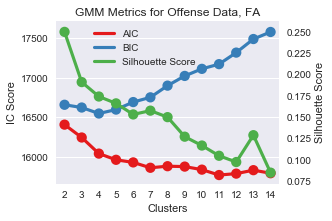

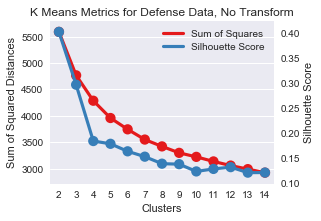

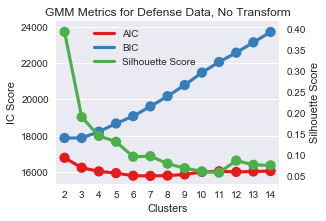

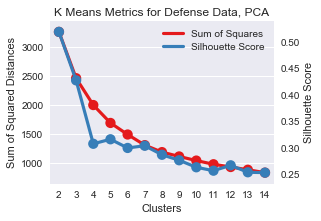

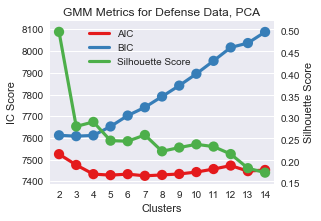

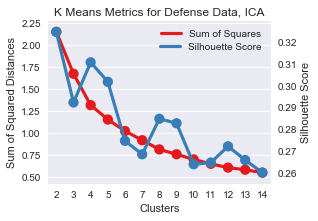

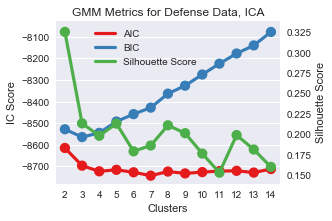

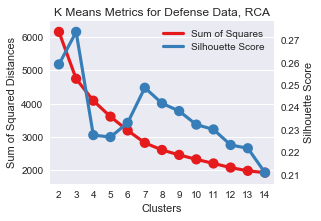

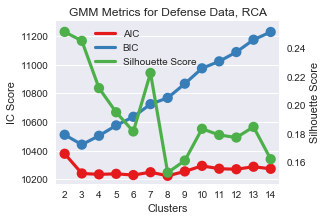

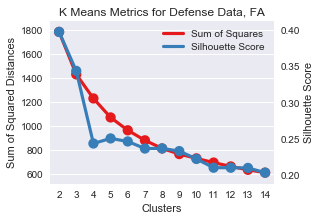

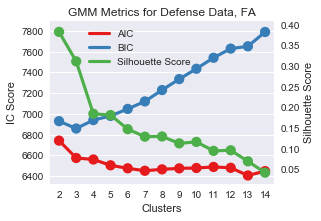

In [190]:
data_dict = {'Offense':{'No Transform':Xo_norm,
                        'PCA':dfpcao[['PC1', 'PC2', 'PC3']].values,
                        'ICA':dficao.values,
                        'RCA':dfrcao.values,
                        'FA':dfrcao.values
                       },
             'Defense':{'No Transform':Xd_norm,
                        'PCA':dfpcad[['PC1', 'PC2', 'PC3']].values,
                        'ICA':dficad.values,
                        'RCA':dfrcad.values,
                        'FA':dffad.values
                       }
            }

for side, dict1 in data_dict.items():
    for transform, d in dict1.items():
        elbow(15, d, 'K Means Metrics for {0} Data, {1}'.format(side, transform))
        aicBic(15, d, 'GMM Metrics for {0} Data, {1}'.format(side, transform))

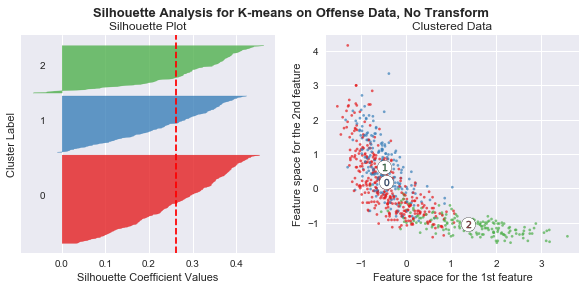

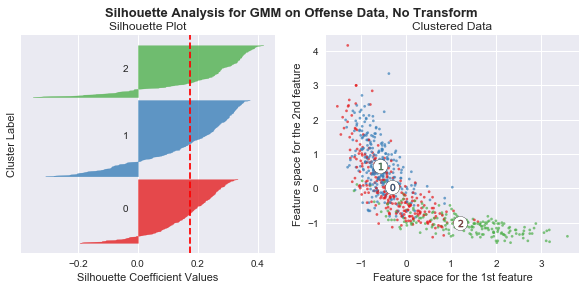

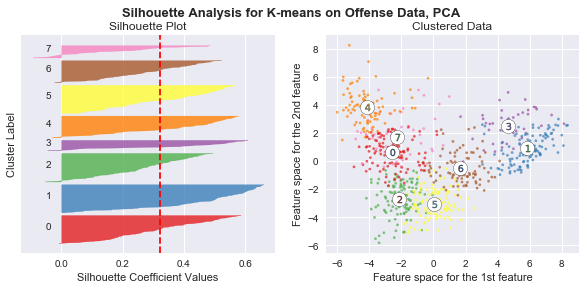

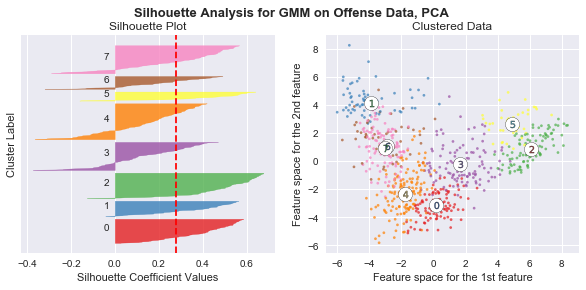

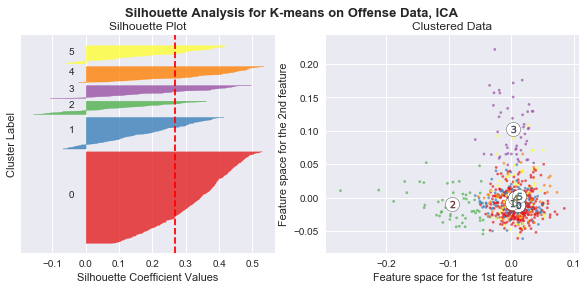

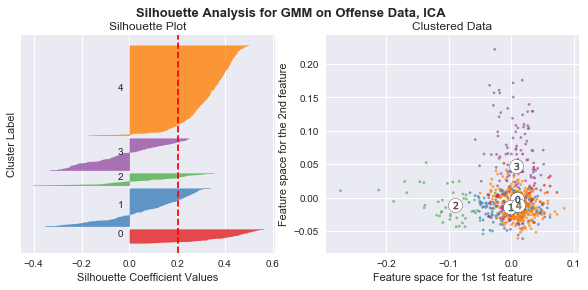

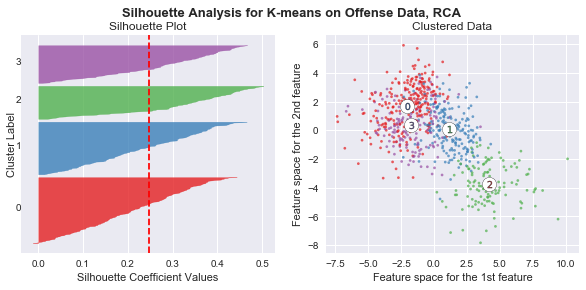

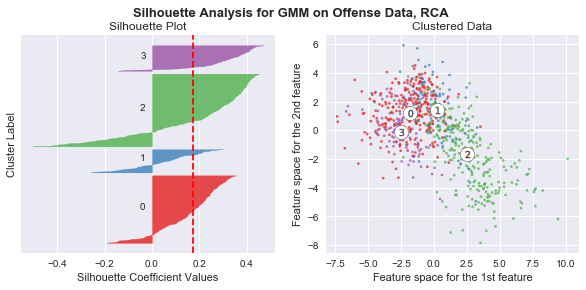

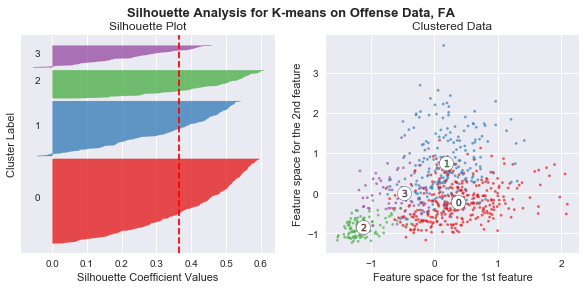

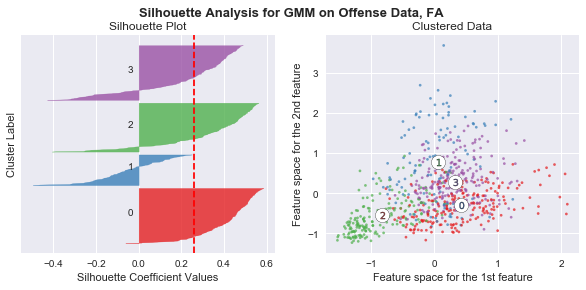

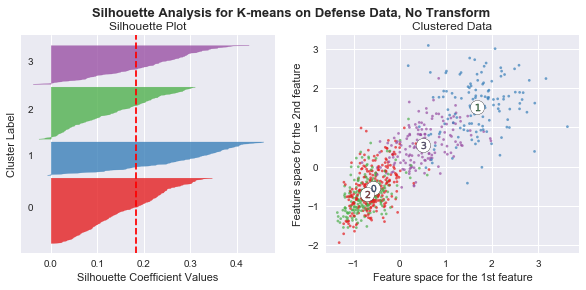

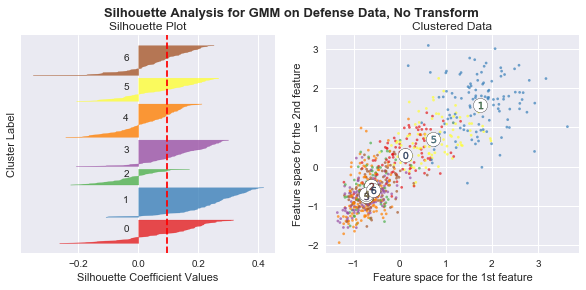

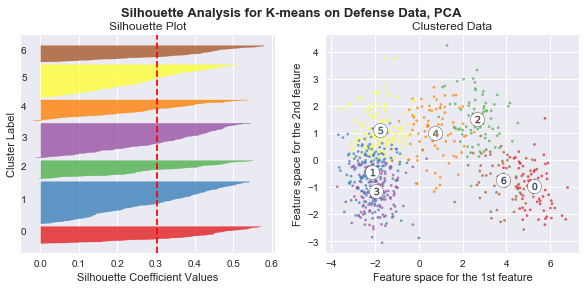

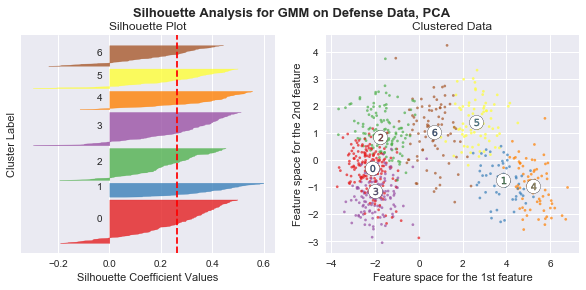

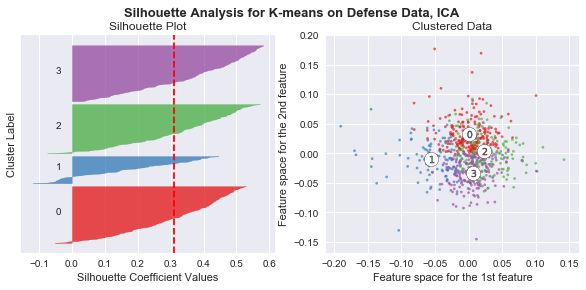

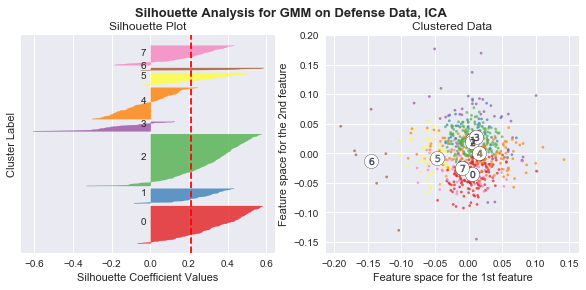

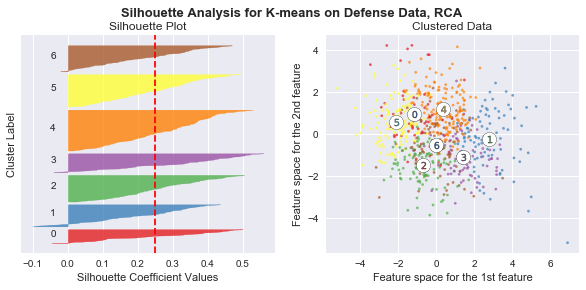

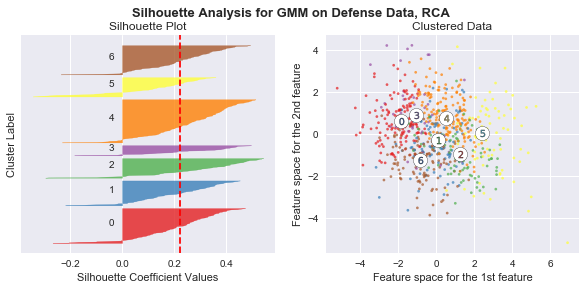

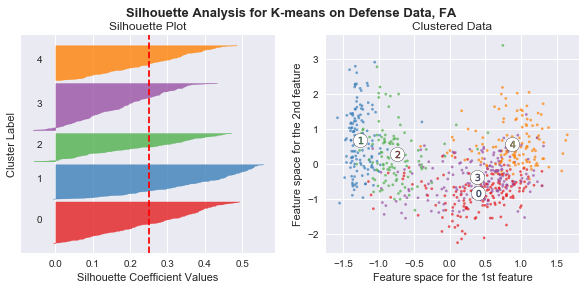

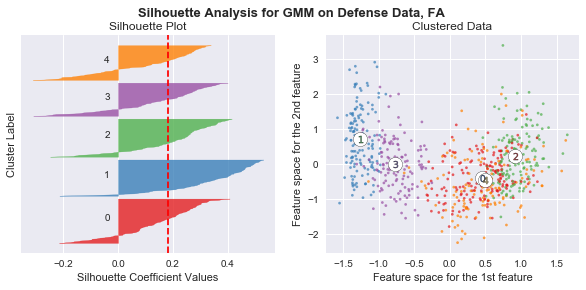

In [191]:
data_dict = {'Offense':{'No Transform':[Xo_norm, 3, 3],
                        'PCA':[dfpcao[['PC1', 'PC2', 'PC3']].values, 8, 8],
                        'ICA':[dficao.values, 6, 5],
                        'RCA':[dfrcao.values, 4, 4],
                        'FA':[dffao.values, 4, 4]
                       },
             'Defense':{'No Transform':[Xd_norm, 4, 7],
                        'PCA':[dfpcad[['PC1', 'PC2', 'PC3']].values, 7, 7],
                        'ICA':[dficad.values, 4, 8],
                        'RCA':[dfrcad.values, 7, 7],
                        'FA':[dffad.values, 5, 5]
                       }
            }

for side, dict1 in data_dict.items():
    for transform, d in dict1.items():
        silhouette(d[1], d[0],
                   'Silhouette Analysis for K-means on {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        silhouette(d[2], d[0],
                   'Silhouette Analysis for GMM on {0} Data, {1}'.format(side, transform),
                   'GMM')

In [20]:
def getClusters(df, df_orig, n_clusters, n_comp, cols, name, algo='Kmeans'):
    X = df.iloc[:, 0:n_comp].values
    
    if algo == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        df['Cluster'] = kmeans.labels_
        df_orig[name] = kmeans.labels_
        centers = kmeans.cluster_centers_
    elif algo == 'GMM':
        gm = gmm(n_components=n_clusters, random_state=0).fit(X)
        df['Cluster'] = gm.predict(X)
        df_orig[name] = gm.predict(X)
        centers = gm.means_
    
    df_orig['Dist'] = 0
    for i in range(n_comp):
        df_orig['Dist'] = df_orig['Dist'] + df.apply(lambda x:
                                                        (x[i] - centers[int(x['Cluster'])][i])**2,
                                                        axis=1)
    df.drop(['Cluster'], inplace=True, axis=1)
    print('-------{}-------'.format(algo))
    print(df_orig.groupby(name).count()['Dist'])
    print(df_orig.groupby([name, 'P']).count()['Dist'])
    print(df_orig.groupby(name).mean()['Dist'])
    print(df_orig.groupby(name).mean()[cols])
    print(df_orig.loc[df_orig.sort_values('Dist',
                                            ascending=False).groupby(name).head().index,
                 ['DISPLAY_FIRST_LAST',
                  'season', name, 'Dist']
                ].sort_values(name))

In [28]:
getClusters(dfpcad, df, 7, 3, dcols, 'PCA_Cluster_D', 'Kmeans')

-------Kmeans-------
PCA_Cluster_D
0     67
1    167
2     73
3    137
4     82
5    129
6     65
Name: Dist, dtype: int64
PCA_Cluster_D  P  
0              C       45
               F        6
               F-C     16
1              F       34
               G      109
               G-F     24
2              C        9
               F       47
               F-C     16
               G-F      1
3              F        6
               G      121
               G-F     10
4              C        2
               F       66
               F-C      3
               G        3
               G-F      8
5              F       50
               G       64
               G-F     15
6              C       34
               F       18
               F-C     13
Name: Dist, dtype: int64
PCA_Cluster_D
0    1.780799
1    1.675081
2    2.121899
3    1.804523
4    1.985724
5    1.882675
6    1.627372
Name: Dist, dtype: float64
               d_DEF_RIM_FGA  d_DREB_CHANCES  d_AVG_DREB_DIST  \
PCA_C

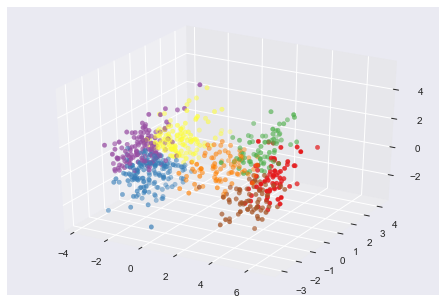

In [29]:
from mpl_toolkits.mplot3d import Axes3D

def plot3D(X, k):
    fig = plt.figure()
    ax = Axes3D(fig)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    colors2 = [colors[x] for x in labels]
    ax.scatter(X[:,0], X[:,1], X[:,2], c = colors2)
    
plot3D(dfpcad[['PC1', 'PC2', 'PC3']].values, 7)

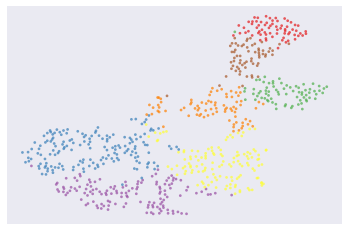

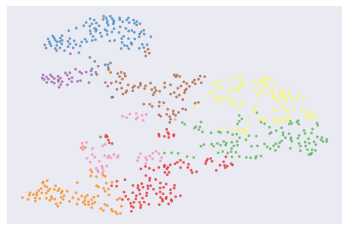

In [30]:
from sklearn.manifold import TSNE

def plotTSNE(X, labels):
    xembed = TSNE().fit_transform(X)
    f, ax = plt.subplots(1,1)
    colors2 = [colors[x] for x in labels]
    ax.scatter(xembed[:,0], xembed[:,1], marker='.', s=30, lw=0, alpha=.7, edgecolor='k',c=colors2)
    ax.set_yticks([])
    ax.set_xticks([])

plotTSNE(dfpcad[['PC1', 'PC2', 'PC3']].values, df['PCA_Cluster_D'].values)
plotTSNE(dfpcao[['PC1', 'PC2', 'PC3']].values, df['PCA_Cluster_O'].values)

In [37]:
dfreb = pd.read_csv('Rebound_Features.csv')

# Get arrays
Xreb = dfreb.values[:,:-1]
yreb = dfreb.values[:,-1]

# Normalize values to 0 mean and 1 standard deviation
Xreb_norm = StandardScaler().fit_transform(Xreb)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


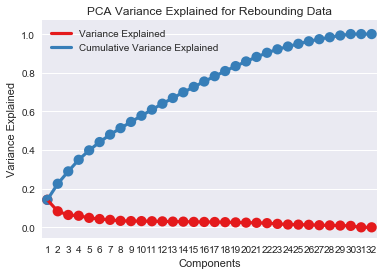

In [55]:
rebpca = transformDF(Xreb_norm, 'PCA', 'PCA Variance Explained for Rebounding Data')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


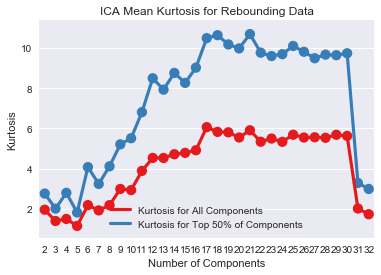

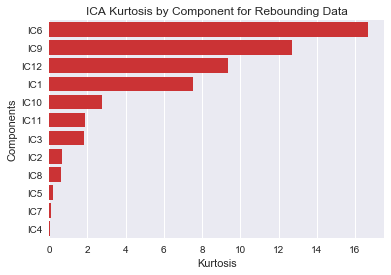

In [57]:
elbowICA(Xreb_norm, 'ICA Mean Kurtosis for Rebounding Data')
rebica = transformDF(Xreb_norm, 'ICA', 'ICA Kurtosis by Component for Rebounding Data', 12)

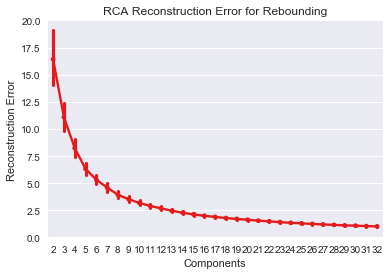

In [63]:
elbowRCA(Xreb_norm, 'RCA Reconstruction Error for Rebounding')
rebrca = transformDF(Xreb_norm, 'RCA', n=5)

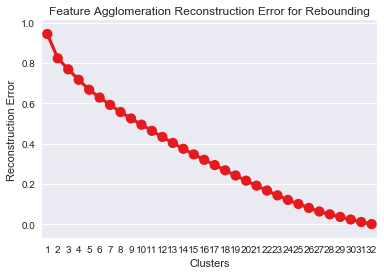

In [66]:
elbowFA(Xreb_norm, 'Feature Agglomeration Reconstruction Error for Rebounding')
rebfa = transformDF(Xreb_norm, 'FA', n=5)

No Transform 1
No Transform 2
No Transform 3
No Transform 4
No Transform 5
PCA 1
PCA 2
PCA 3
PCA 4
PCA 5
ICA 1
ICA 2
ICA 3
ICA 4
ICA 5
RCA 1
RCA 2
RCA 3
RCA 4
RCA 5
FA 1
FA 2
FA 3
FA 4
FA 5


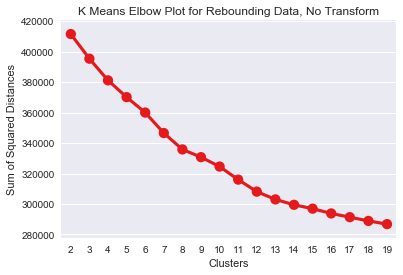

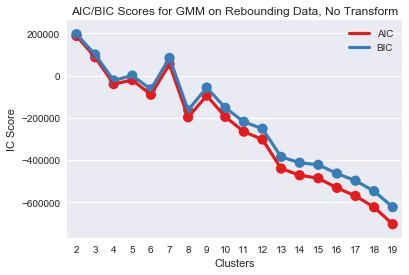

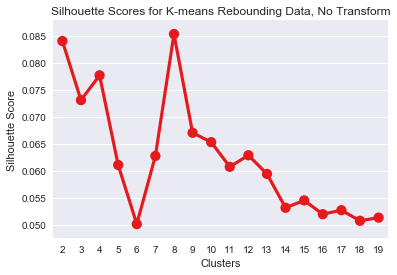

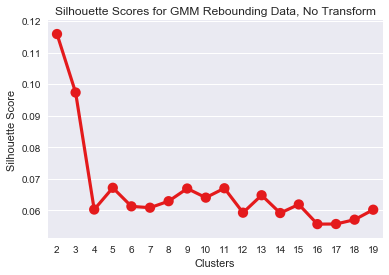

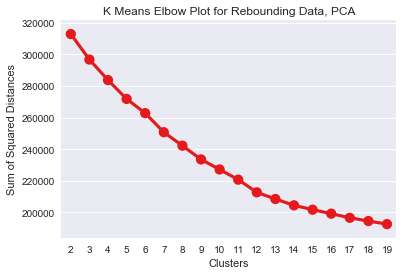

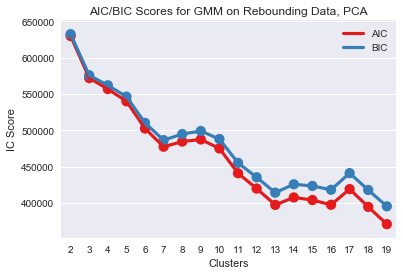

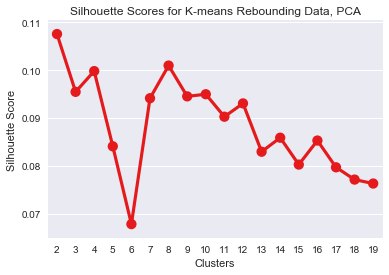

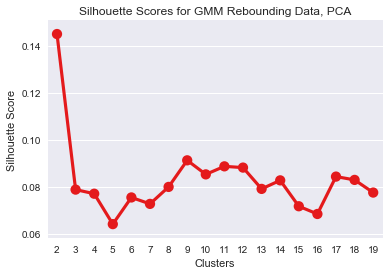

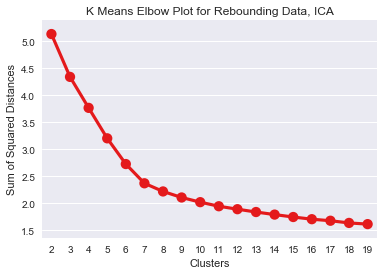

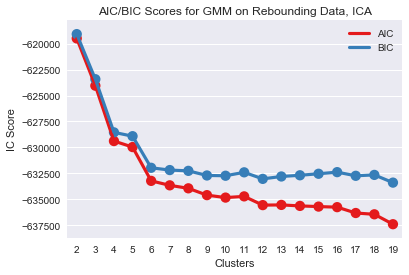

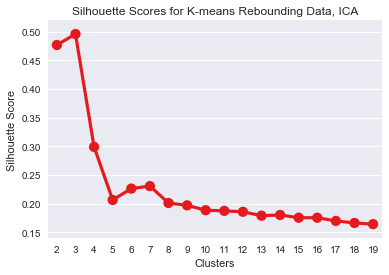

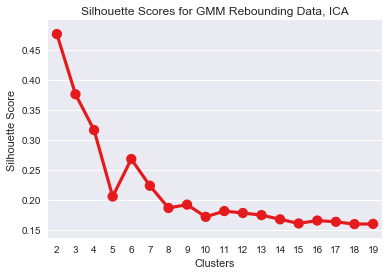

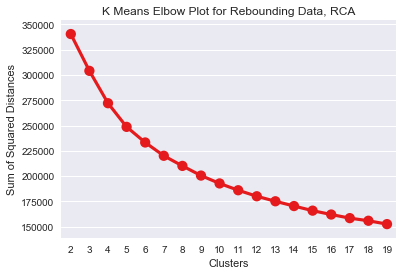

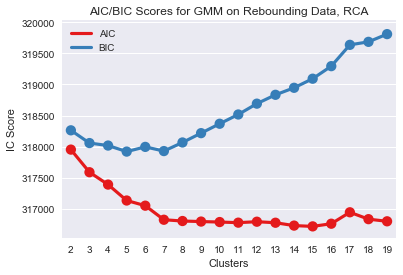

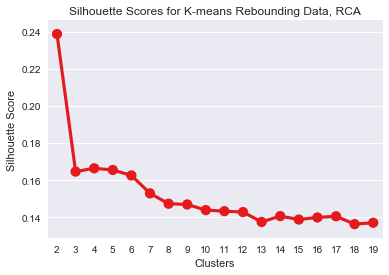

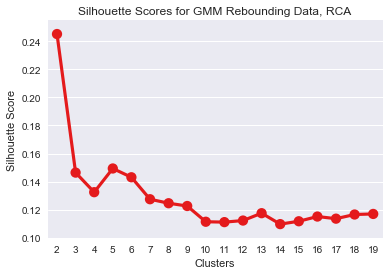

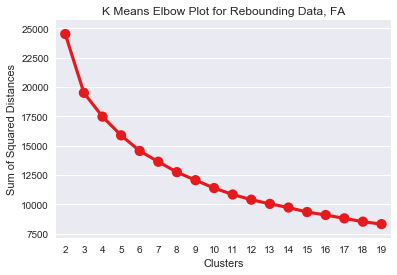

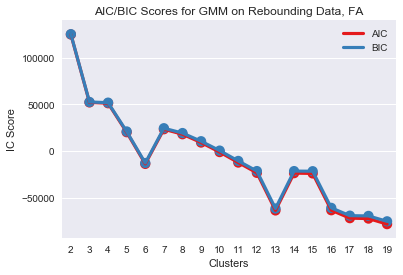

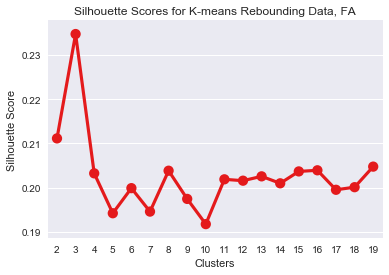

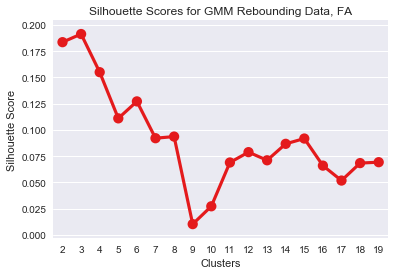

In [70]:
data_reb_dict = {'Rebounding': {'No Transform':Xreb_norm,
                                'PCA':rebpca.values[:,:17],
                                'ICA':rebica.values,
                                'RCA':rebrca.values,
                                'FA':rebfa.values
                           }
            }

for side, dict1 in data_reb_dict.items():
    for transform, d in dict1.items():
        print(transform + ' 1')
        elbow(20, d, 'K Means Elbow Plot for {0} Data, {1}'.format(side, transform))
        print(transform + ' 2')
        aicBic(20, d, 'AIC/BIC Scores for GMM on {0} Data, {1}'.format(side, transform))
        print(transform + ' 3')
        sil_scores(20, d, 'Silhouette Scores for K-means {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        print(transform + ' 4')
        sil_scores(20, d, 'Silhouette Scores for GMM {0} Data, {1}'.format(side, transform),
                   'GMM')
        print(transform + ' 5')

No Transform 1
No Transform 2
PCA 1
PCA 2
ICA 1
ICA 2
RCA 1
RCA 2
FA 1
FA 2


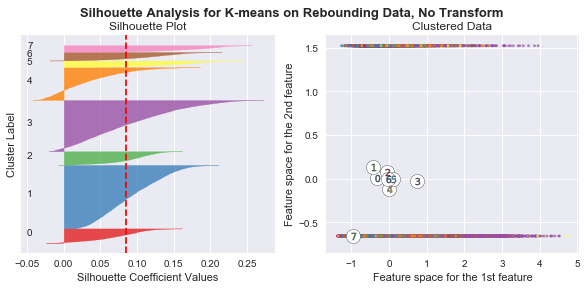

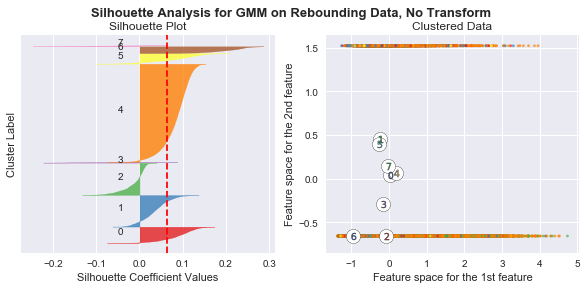

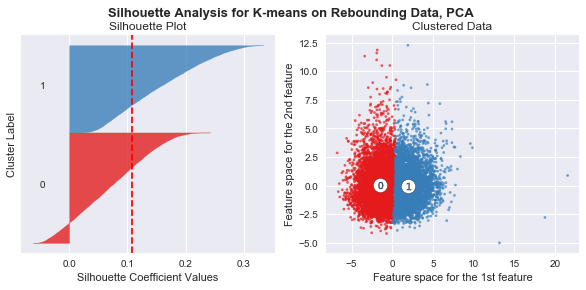

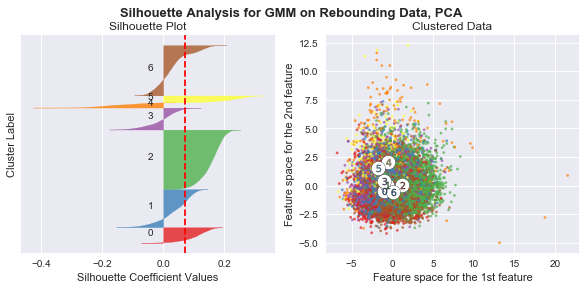

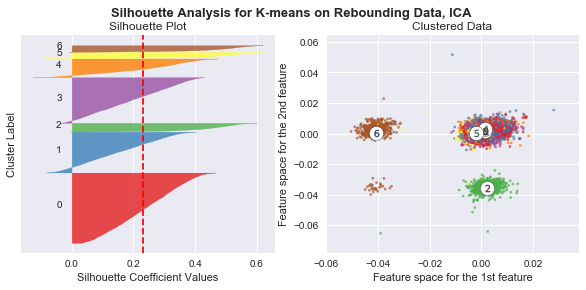

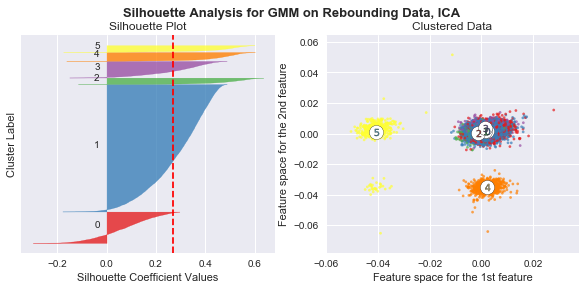

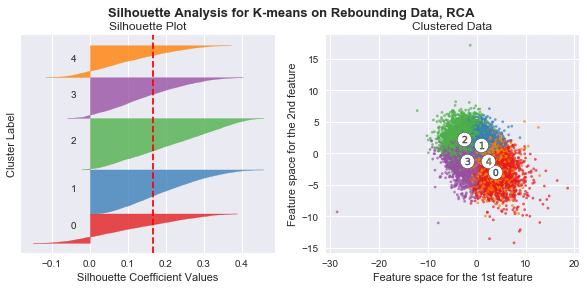

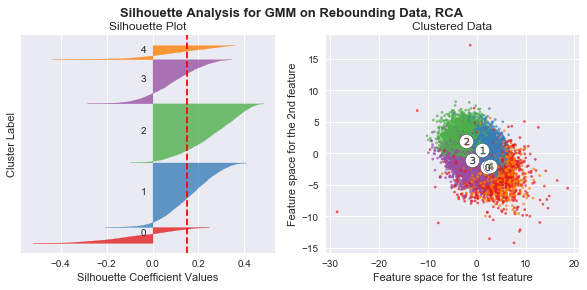

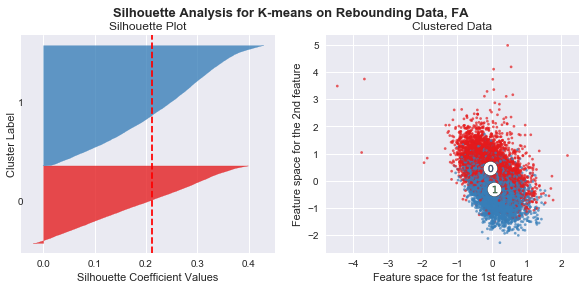

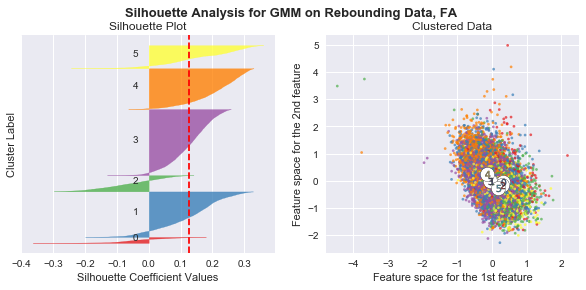

In [71]:
data_reb_dict = {'Rebounding': {'No Transform':[Xreb_norm, 8, 8],
                                'PCA':[rebpca.values[:,:17], 2, 7],
                                'ICA':[rebica.values, 7, 6],
                                'RCA':[rebrca.values, 5, 5],
                                'FA':[rebfa.values, 2, 6]
                           }
            }

for side, dict1 in data_reb_dict.items():
    for transform, d in dict1.items():
        print(transform + ' 1')
        silhouette(d[1], d[0],
                   'Silhouette Analysis for K-means on {0} Data, {1}'.format(side, transform),
                   'Kmeans')
        print(transform + ' 2')
        silhouette(d[2], d[0],
                   'Silhouette Analysis for GMM on {0} Data, {1}'.format(side, transform),
                   'GMM')